In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

In [2]:
# Read the datafile
df = pd.read_csv("VAW.csv", na_values=[" ", "_T: Any"], encoding="utf-8")

#### Preprocessing

In [3]:
df.columns = df.columns.map(lambda x : x.split(":")[0])

In [4]:
df.replace(to_replace=r"\:(.*)", value="", inplace=True, regex=True)

In [5]:
df["TIME_PERIOD"] = pd.to_datetime(arg=df["TIME_PERIOD"], format="%Y")
df["OBS_VALUE"] = pd.to_numeric(arg=df["OBS_VALUE"])

object_colnames = df.select_dtypes(include="object").columns
df[object_colnames] = df[object_colnames].astype("category")

In [6]:
df.head(5)

,DATAFLOW,FREQ,TIME_PERIOD,GEO_PICT,TOPIC,INDICATOR,SEX,AGE,CONDITION,VIOLENCE_TYPE,...,OUTCOME,RESPONSE,HELP_REASON,HELP_PROVIDER,OBS_VALUE,UNIT_MEASURE,UNIT_MULT,OBS_STATUS,DATA_SOURCE,OBS_COMMENT
0,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,CONT_ECON,...,NaN,NaN,NaN,NaN,6.2,PERCENT,NaN,NaN,FHSS,NaN
1,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,EMO,...,NaN,NaN,NaN,NaN,9.6,PERCENT,NaN,NaN,FHSS,NaN
2,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,EMO,...,NaN,NaN,NaN,NaN,26.7,PERCENT,NaN,NaN,FHSS,NaN
3,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,PHYS,...,NaN,NaN,NaN,NaN,6.7,PERCENT,NaN,NaN,FHSS,NaN
4,SPC,A,2013-01-01,CK,VAW_TOPIC_001,NUMPERRF,F,Y15T64,EVPART,PHYS,...,NaN,NaN,NaN,NaN,30.2,PERCENT,NaN,NaN,FHSS,NaN


In [7]:
# Dataframe without missing values on OUTCOME

df_train = df.dropna(subset=["OUTCOME"]).copy()

#### Some more preprocessing to discard columns with NA's

In [8]:
# Filter features > 80% NA's

print("Keep columns that have at least", np.int16(df_train.shape[0]*.2), "non NA rows")
df_train = df_train.dropna(axis=1, thresh=np.int16(df_train.shape[0]*.2)).copy()

Keep columns that have at least 108 non NA rows


In [9]:
# Omit columns that have the same value in all rows

df_train = df_train[df_train.columns[df_train.nunique() > 1]]

In [10]:
# Drop time period
year_df_train = pd.concat([df["TIME_PERIOD"], df["OUTCOME"], df["OBS_VALUE"]],axis=1, ignore_index=False)

df_train = df_train.drop(columns=["TIME_PERIOD"])

In [11]:
X, y = df_train.drop(columns=["OUTCOME"]), df_train["OUTCOME"]

In [12]:
# Condense categories to just the 5 most important

#map_new_cat_s = {"Health" : ['HEALTHAFF', 'HEALTHSTA', 'HURT', 'INJ', 'LOSCONS', 'PAIN',
#                            'PROBMEM', 'PROBUSUAL', 'PROBWALK'],
#                        "Children" : ['AL1CHILDAGGR', 'AL1CHILDBEDW', 'AL1CHILDDSCH',
#                                     'AL1CHILDNIGHT', 'AL1CHILDQUIET', 'AL1CHILDRSCH'],
#                        "Mental" : ['EMODIST', 'SUICIDEATT', 'SUICIDETHI', 'LOSCONF'],
#                        "Work" : ['WORK', 'CONCENTRATE', 'DISWORK'],
#                        "Reproduce" : ['ABOR', 'MISC', 'STILB']}

#s = pd.Series(map_new_cat_s).explode().sort_values()

#y = y.map(dict(zip(s.values, s.index))).astype("category")

#### Some plots

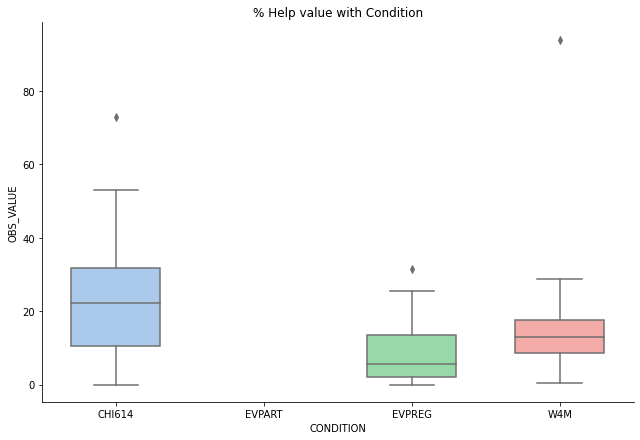

In [13]:
sns.catplot(x="CONDITION", y="OBS_VALUE", kind="box", palette="pastel", data=df_train, width=.6,height=6, aspect=1.5) \
    .set(title="% Help value with Condition")
plt.show()

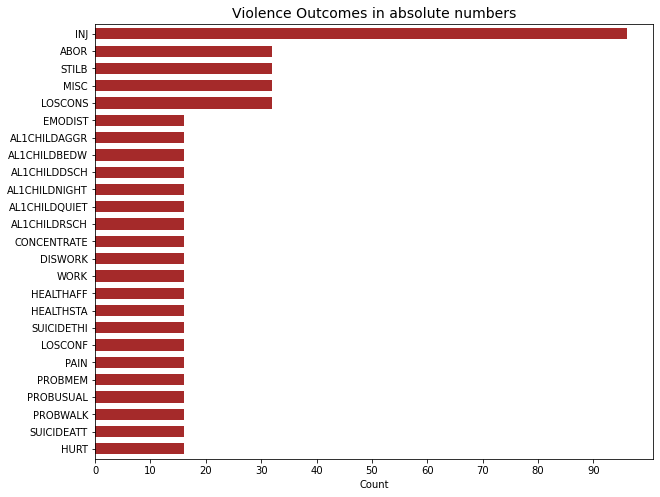

In [14]:
ax = y.value_counts(normalize=False, ascending=True).plot.barh(figsize=(10,8), width=.65, align="center",
                                                             color="brown")

ax.set_xticks(np.arange(0,100, 10))
ax.set_xlabel("Count")
ax.set_title("Violence Outcomes in absolute numbers", fontsize=14)
plt.show()

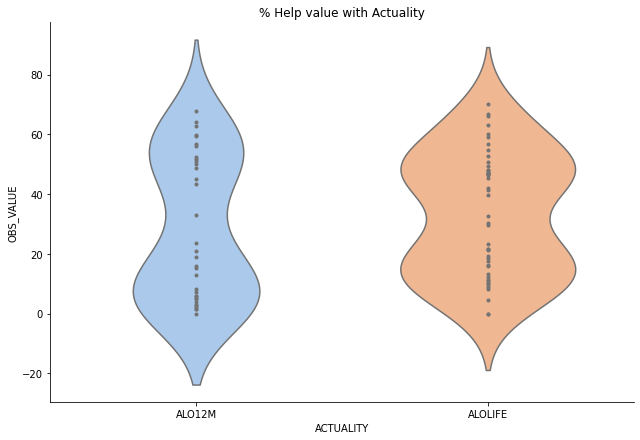

In [15]:
sns.catplot(x="ACTUALITY", y="OBS_VALUE", kind="violin", inner="point", bw="scott", palette="pastel", scale="count", data=df_train, width=.6,height=6, aspect=1.5) \
    .set(title="% Help value with Actuality")
plt.show()

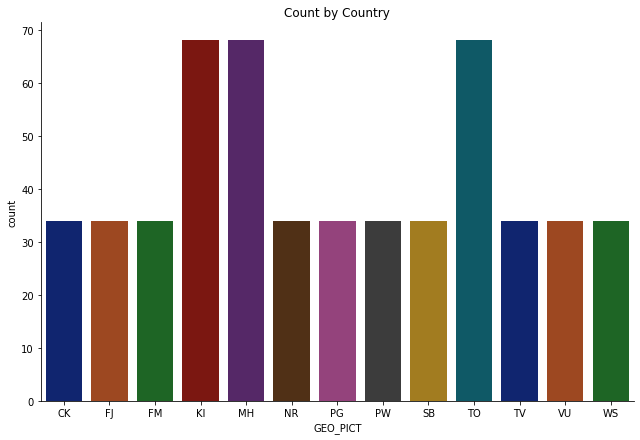

In [16]:
sns.catplot(x="GEO_PICT", data=df_train, palette="dark", kind="count", height=6, aspect=1.5) \
        .set(title="Count by Country")
plt.show()

In [17]:
# Prepare dataframe to print year only

year_df_train = year_df_train[year_df_train["OUTCOME"].notna()]
year_df_train["TIME_PERIOD"] = year_df_train["TIME_PERIOD"].dt.year.copy()

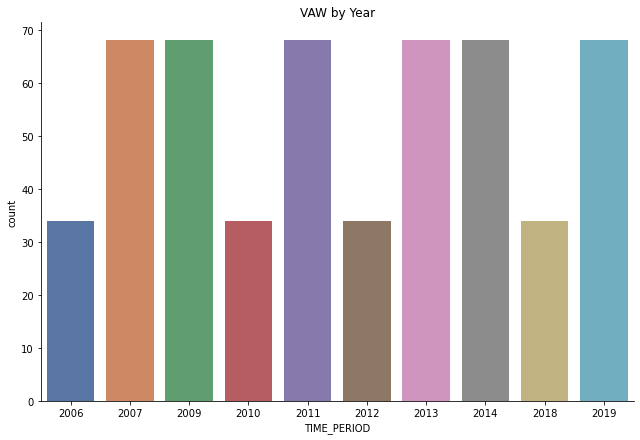

In [18]:
sns.catplot(x="TIME_PERIOD", data=year_df_train, palette="deep", kind="count", height=6, aspect=1.5) \
        .set(title="VAW by Year")
plt.show()

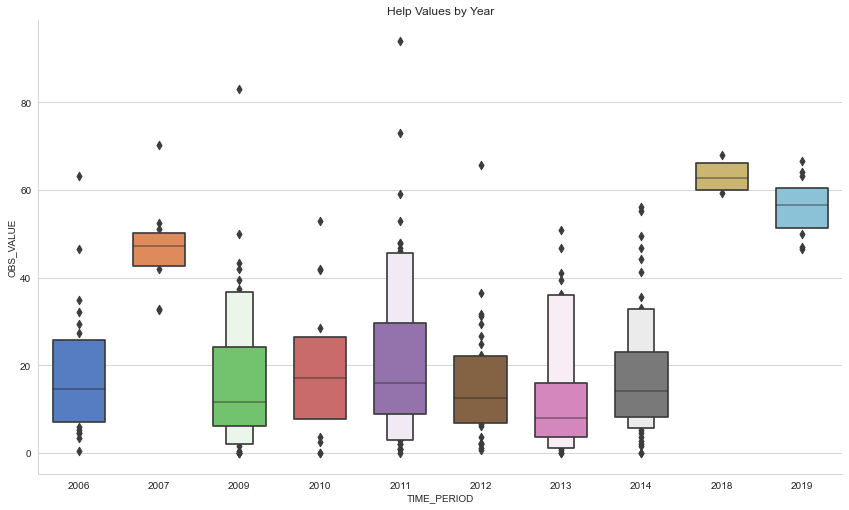

In [19]:
sns.set_style("whitegrid")
sns.catplot(x="TIME_PERIOD", y="OBS_VALUE", data=year_df_train, palette="muted", kind="boxen",
            height=7, aspect=1.7, width=.65,linewidth=1.7, saturation=0.8) \
        .set(title="Help Values by Year")
plt.show()

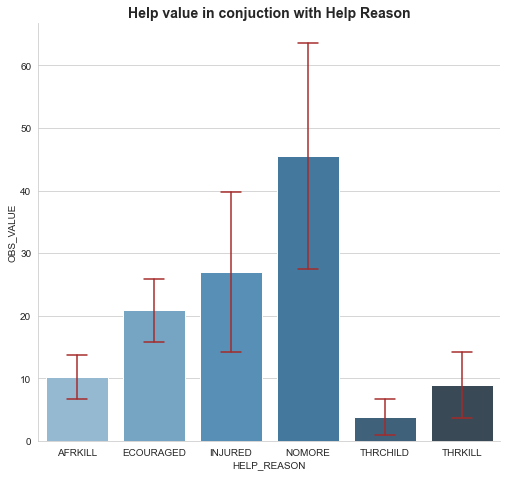

In [20]:
sns.catplot(kind="bar", x="HELP_REASON", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=6.5, aspect=1.1,
          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")

plt.title("Help value in conjuction with Help Reason", fontdict={'size':14, 'weight' : 'bold'})
plt.show()

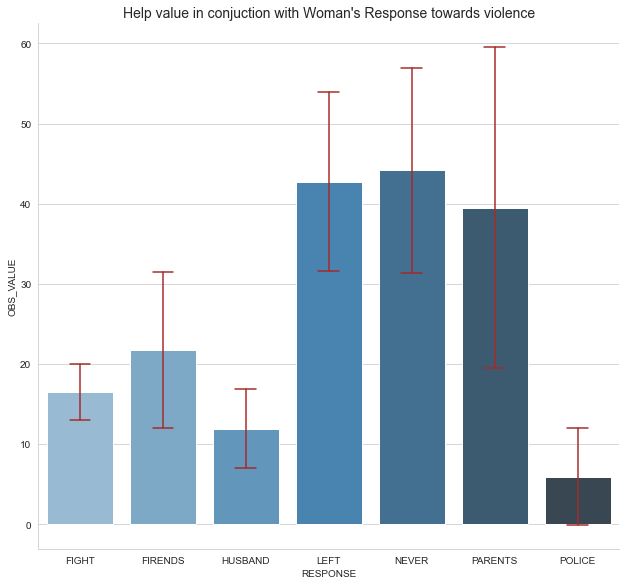

In [21]:
sns.catplot(kind="bar", x="RESPONSE", y="OBS_VALUE", data=df, palette="Blues_d", orient="v", height=8, aspect=1.1,
          ci="sd", capsize=.25 ,errwidth=1.5, errcolor="brown")

plt.title("Help value in conjuction with Woman's Response towards violence", fontdict={'size':14})
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=132, stratify=y)

In [23]:
# Impute values

imputer_numeric = SimpleImputer(strategy="median")

X_train["OBS_VALUE"] = imputer_numeric.fit_transform(X_train["OBS_VALUE"].values.reshape(-1,1))
X_test["OBS_VALUE"] = imputer_numeric.transform(X_test["OBS_VALUE"].values.reshape(-1,1))

In [24]:
# Fill NA categorical features with "NA"

imputer = SimpleImputer(strategy="constant", fill_value="NA")

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test =  pd.DataFrame(imputer.transform(X_test), columns=X.columns)

In [25]:
# One-Hot encode and scale numeric values

categorical_cols = X.select_dtypes(exclude="float").columns
numeric_cols = X.select_dtypes(include="float").columns

col_transformer_train = ColumnTransformer([('cat_cols', OneHotEncoder(handle_unknown="ignore"), categorical_cols),
                                ('num_cols', StandardScaler(), numeric_cols)])

X_train = col_transformer_train.fit_transform(X_train).toarray()
X_test = col_transformer_train.transform(X_test).toarray()

In [26]:
# Label encoder y

le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Run ML Algos

##### Decision Trees

In [27]:
parameters = {'criterion':('gini', 'entropy'), 'max_features' : [20, 22, 24, 26], "min_samples_leaf":[1, 2],
             'max_depth':[3, 4, 5, 6], 'max_leaf_nodes':[8, 9, 10, 11, 15, 20], 
              'min_impurity_decrease':[1e-3, 5e-2, 1e-2]}

clf0 = GridSearchCV(DecisionTreeClassifier(random_state=132), parameters, scoring="f1_micro", n_jobs=2, verbose=1)

clf0.fit(X_train, y_train)

print(clf0.best_params_)
print(clf0.scorer_)
print("Best cv score", clf0.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf0.predict(X_test), average="micro"))

#clf = DecisionTreeClassifier(criterion="gini", random_state=132, max_features=23, min_samples_leaf=5, max_depth=6, 
#                                 max_leaf_nodes=15, min_impurity_decrease=.005)
#clf.fit(X_train, y_train)
#clf.score(X_test, y_test)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 26, 'max_leaf_nodes': 11, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.3773261065943993
F1 Score on held out data 0.3897058823529412


In [28]:
print(classification_report(y_test, clf0.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.571     0.500     0.533         8
 AL1CHILDAGGR      0.167     1.000     0.286         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.000     0.000     0.000         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.250     1.000     0.400         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.200     0.500     0.286         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.955     0.875     0.913        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.571     1.000     0.727         8
         MISC      0.471     1.000     0.640         8
         

##### Logistic Regression

In [29]:
clf1 = LogisticRegression(solver="liblinear", random_state=132, max_iter=100, C=.75, penalty="l1")

clf1.fit(X_train, y_train)

print("F1 Score on held out data", f1_score(y_test, clf1.predict(X_test), average="micro"))

F1 Score on held out data 0.4044117647058824


In [30]:
print(classification_report(y_test, clf1.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.500     0.500     0.500         8
 AL1CHILDAGGR      0.222     0.500     0.308         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.308     1.000     0.471         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.200     0.250     0.222         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.200     0.500     0.286         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.885     0.958     0.920        24
      LOSCONF      0.333     0.750     0.462         4
      LOSCONS      0.600     0.750     0.667         8
         MISC      0.500     1.000     0.667         8
         

##### Bagging

In [31]:
base = DecisionTreeClassifier(criterion="gini", random_state=132, max_features=23, min_samples_leaf=5, max_depth=6, 
                                 max_leaf_nodes=15, min_impurity_decrease=.005)

parameters = {'n_estimators':[25, 30, 35, 40, 50], 'max_samples' : [.60, .65, .7, .75, .8, .85, .9, 1],
              'max_features' :[.55, .65, .75, .85]}

clf2 = GridSearchCV(BaggingClassifier(base_estimator=base, random_state=132), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=5)

clf2.fit(X_train, y_train)

print(clf2.best_params_)
print(clf2.scorer_)
print("Best cv score", clf2.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf2.predict(X_test), average="micro"))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
{'max_features': 0.85, 'max_samples': 0.85, 'n_estimators': 40}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.35546522131887986
F1 Score on held out data 0.4264705882352941


In [32]:
print(classification_report(y_test, clf2.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.800     0.500     0.615         8
 AL1CHILDAGGR      0.250     0.250     0.250         4
 AL1CHILDBEDW      0.273     0.750     0.400         4
 AL1CHILDDSCH      0.500     0.500     0.500         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.500     0.250     0.333         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.250     0.250     0.250         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.333     0.500     0.400         4
    HEALTHSTA      0.250     0.250     0.250         4
         HURT      0.000     0.000     0.000         4
          INJ      0.913     0.875     0.894        24
      LOSCONF      0.250     0.250     0.250         4
      LOSCONS      0.538     0.875     0.667         8
         MISC      0.444     0.500     0.471         8
         

##### Random Forest

In [33]:
parameters = {'n_estimators':[90, 100, 110],'max_depth' : [9,10,11], 
              'max_leaf_nodes':[5, 10], 'max_features':["log2", 42],
              'max_samples':[.85, .9]}

clf3 = GridSearchCV(RandomForestClassifier(criterion="gini", random_state=132), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=10)

clf3.fit(X_train, y_train)

print(clf3.best_params_)
print(clf3.scorer_)
print("Best cv score", clf3.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf3.predict(X_test), average="micro"))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
{'max_depth': 9, 'max_features': 42, 'max_leaf_nodes': 10, 'max_samples': 0.85, 'n_estimators': 100}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.3826219512195122
F1 Score on held out data 0.4411764705882353


In [34]:
print(classification_report(y_test, clf3.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.800     0.500     0.615         8
 AL1CHILDAGGR      0.000     0.000     0.000         4
 AL1CHILDBEDW      0.214     0.750     0.333         4
 AL1CHILDDSCH      0.500     0.500     0.500         4
AL1CHILDNIGHT      1.000     0.250     0.400         4
AL1CHILDQUIET      0.333     0.250     0.286         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.231     0.750     0.353         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.333     0.500     0.400         4
    HEALTHSTA      0.250     0.250     0.250         4
         HURT      0.000     0.000     0.000         4
          INJ      0.913     0.875     0.894        24
      LOSCONF      0.333     0.250     0.286         4
      LOSCONS      0.538     0.875     0.667         8
         MISC      1.000     0.375     0.545         8
         

##### KNN

In [35]:
parameters = {'n_neighbors':[40, 50, 60, 100, 130],'weights' : ('uniform', 'distance'), 
              'p':[1, 2], 'leaf_size':[10, 15, 20, 25, 30]}

clf4 = GridSearchCV(KNeighborsClassifier(algorithm="kd_tree"), parameters, 
                   scoring="f1_micro", n_jobs=2, verbose=1, cv=5)

clf4.fit(X_train, y_train)

print(clf4.best_params_)
print(clf4.scorer_)
print("Best cv score", clf4.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf4.predict(X_test), average="micro"))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'leaf_size': 15, 'n_neighbors': 60, 'p': 2, 'weights': 'uniform'}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.3480277024992472
F1 Score on held out data 0.33088235294117646


In [36]:
print(classification_report(y_test, clf4.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.500     0.500     0.500         8
 AL1CHILDAGGR      0.333     0.250     0.286         4
 AL1CHILDBEDW      0.250     0.750     0.375         4
 AL1CHILDDSCH      0.000     0.000     0.000         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.200     0.250     0.222         4
  CONCENTRATE      0.111     0.250     0.154         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.200     0.250     0.222         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.649     1.000     0.787        24
      LOSCONF      0.200     0.250     0.222         4
      LOSCONS      0.000     0.000     0.000         8
         MISC      0.500     0.875     0.636         8
         

##### SVM

In [37]:
parameters = {'kernel':('linear', 'sigmoid', 'poly'), 'C':[.1, .5, 1, 2, 15], "tol":[1e-2, 2e-3, 1e-3, 1e-4],
             'degree':[1,2,3]}

clf5 = GridSearchCV(SVC(random_state=132), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf5.fit(X_train, y_train)

print(clf5.best_params_)
print(clf5.scorer_)
print("Best cv score", clf5.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf5.predict(X_test), average="micro"))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'C': 1, 'degree': 1, 'kernel': 'sigmoid', 'tol': 0.01}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.32098765432098764
F1 Score on held out data 0.3161764705882353


In [38]:
print(classification_report(y_test, clf5.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.400     0.500     0.444         8
 AL1CHILDAGGR      0.200     0.250     0.222         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.250     0.250     0.250         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.167     0.250     0.200         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.250     0.500     0.333         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.840     0.875     0.857        24
      LOSCONF      1.000     0.250     0.400         4
      LOSCONS      0.455     0.625     0.526         8
         MISC      1.000     0.250     0.400         8
         

##### Neural Networks

In [39]:
parameters = {'activation':('logistic', 'tanh'), 'hidden_layer_sizes':((32,64),(64,64)),
             'learning_rate_init':[1e-5, 1e-4, 1e-3]}

clf6 = MLPClassifier(hidden_layer_sizes=(256,256), activation="logistic", learning_rate_init=3e-3,
                    max_iter=2000, random_state=42, tol=0.01)

clf6.fit(X_train, y_train)

print("F1 Score on held out data", f1_score(y_test, clf6.predict(X_test), average="micro"))

F1 Score on held out data 0.4117647058823529


In [40]:
print(classification_report(y_test, clf6.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.000     0.000     0.000         8
 AL1CHILDAGGR      0.000     0.000     0.000         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.250     0.500     0.333         4
AL1CHILDNIGHT      0.250     1.000     0.400         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.000     0.000     0.000         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.222     0.500     0.308         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.885     0.958     0.920        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.600     0.750     0.667         8
         MISC      0.538     0.875     0.667         8
         

##### Gradient Boosting

In [41]:
clf7 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,
                                subsample=.9, min_samples_split=10, 
                                 random_state=142, max_features=30,
                                max_depth=30)

clf7.fit(X_train, y_train)
print("F1 Score on held out data", f1_score(y_test, clf7.predict(X_test), average="micro"))

F1 Score on held out data 0.25735294117647056


In [42]:
print(classification_report(y_test, clf7.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.417     0.625     0.500         8
 AL1CHILDAGGR      0.000     0.000     0.000         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.250     0.250     0.250         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.000     0.000     0.000         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.167     0.250     0.200         4
    HEALTHSTA      0.333     0.250     0.286         4
         HURT      0.250     0.250     0.250         4
          INJ      0.833     0.833     0.833        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.250     0.250     0.250         8
         MISC      0.429     0.375     0.400         8
         

##### LDA

In [43]:
parameters = {'solver':('lsqr', 'svd'), 'tol':[1e-5, 1e-4, 1e-3]}

clf8 = GridSearchCV(LinearDiscriminantAnalysis(), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf8.fit(X_train, y_train)

print(clf8.best_params_)
print(clf8.scorer_)
print("Best cv score", clf8.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf8.predict(X_test), average="micro"))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'solver': 'svd', 'tol': 1e-05}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.12252333634447454
F1 Score on held out data 0.11029411764705882


In [44]:
print(classification_report(y_test, clf8.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.045     0.125     0.067         8
 AL1CHILDAGGR      0.000     0.000     0.000         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.000     0.000     0.000         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.000     0.000     0.000         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.143     0.250     0.182         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.167     0.500     0.250         4
          INJ      0.092     0.250     0.135        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.500     0.625     0.556         8
         MISC      0.000     0.000     0.000         8
         

##### NuSVC

In [45]:
parameters = {'nu' : [2e-3, 1e-3, 3e-3, 1e-1, .15], 'kernel':('poly','rbf','linear'),
             'tol':[1e-4, 1e-3, 1e-2]}

clf9 = GridSearchCV(NuSVC(random_state=142), parameters, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf9.fit(X_train, y_train)

print(clf9.best_params_)
print(clf9.scorer_)
print("Best cv score", clf9.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf9.predict(X_test), average="micro"))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'kernel': 'rbf', 'nu': 0.001, 'tol': 0.01}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.3310448660042156
F1 Score on held out data 0.3014705882352941


In [46]:
print(classification_report(y_test, clf9.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.000     0.000     0.000         8
 AL1CHILDAGGR      0.067     0.250     0.105         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.000     0.000     0.000         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.000     0.000     0.000         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.000     0.000     0.000         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.840     0.875     0.857        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.455     0.625     0.526         8
         MISC      0.000     0.000     0.000         8
         

##### XGBoost

In [47]:
xgboost_params = {'objective':'binary:logistic', 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 1e-2,
                 'verbosity':0, 'booster':'gbtree', 'gamma': 1.25, 'random_state':142, 'eval_metric':'mlogloss',
                 'use_label_encoder' : (False)}

clf10 = MultiOutputClassifier(XGBClassifier(**xgboost_params), n_jobs=2)

clf10.fit(X_train, y_train[:, np.newaxis])

print("F1 Score on held out data", f1_score(y_test, clf10.predict(X_test), average="micro"))

F1 Score on held out data 0.4264705882352941


In [48]:
print(classification_report(y_test, clf10.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.571     0.500     0.533         8
 AL1CHILDAGGR      0.250     0.250     0.250         4
 AL1CHILDBEDW      0.000     0.000     0.000         4
 AL1CHILDDSCH      0.235     1.000     0.381         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.500     0.250     0.333         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      1.000     0.500     0.667         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.000     0.000     0.000         4
    HEALTHAFF      0.222     0.500     0.308         4
    HEALTHSTA      1.000     0.250     0.400         4
         HURT      0.000     0.000     0.000         4
          INJ      0.913     0.875     0.894        24
      LOSCONF      0.286     1.000     0.444         4
      LOSCONS      0.538     0.875     0.667         8
         MISC      0.471     1.000     0.640         8
         

##### AdaBoost

In [49]:
adaboost_params = {'n_estimators' : [10, 20, 30, 40, 50, 75, 100], 'learning_rate' : [1e-2, 5e-2, 5e-1, 1e-1, 1,]}

clf11 = GridSearchCV(AdaBoostClassifier(random_state=132), 
                     adaboost_params, verbose=1, n_jobs=2, cv=5, scoring="f1_micro")

clf11.fit(X_train, y_train)

print(clf11.best_params_)
print(clf11.scorer_)
print("Best cv score", clf11.best_score_)
print("F1 Score on held out data", f1_score(y_test, clf11.predict(X_test), average="micro"))

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'learning_rate': 0.5, 'n_estimators': 20}
make_scorer(f1_score, pos_label=None, average=micro)
Best cv score 0.32363745859680815
F1 Score on held out data 0.3382352941176471


In [50]:
print(classification_report(y_test, clf11.predict(X_test), target_names=y.cat.categories, 
                            digits=3, zero_division=0))

               precision    recall  f1-score   support

         ABOR      0.333     1.000     0.500         8
 AL1CHILDAGGR      0.000     0.000     0.000         4
 AL1CHILDBEDW      0.174     1.000     0.296         4
 AL1CHILDDSCH      0.000     0.000     0.000         4
AL1CHILDNIGHT      0.000     0.000     0.000         4
AL1CHILDQUIET      0.000     0.000     0.000         4
 AL1CHILDRSCH      0.000     0.000     0.000         4
  CONCENTRATE      0.250     1.000     0.400         4
      DISWORK      0.000     0.000     0.000         4
      EMODIST      0.133     1.000     0.235         4
    HEALTHAFF      0.333     0.500     0.400         4
    HEALTHSTA      0.000     0.000     0.000         4
         HURT      0.000     0.000     0.000         4
          INJ      0.667     1.000     0.800        24
      LOSCONF      0.000     0.000     0.000         4
      LOSCONS      0.000     0.000     0.000         8
         MISC      0.000     0.000     0.000         8
         

In [51]:
# Define a classifier to use for predictions
# we choose the one with the highest accuracy, in our case the Random Forest (clf3)
best_classifier = max([(clf, clf.score(X_test, y_test.reshape(-1,1))) for clf in 
                        [clf0, clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, clf11]], key=lambda x : x[1])[0]

clf = best_classifier

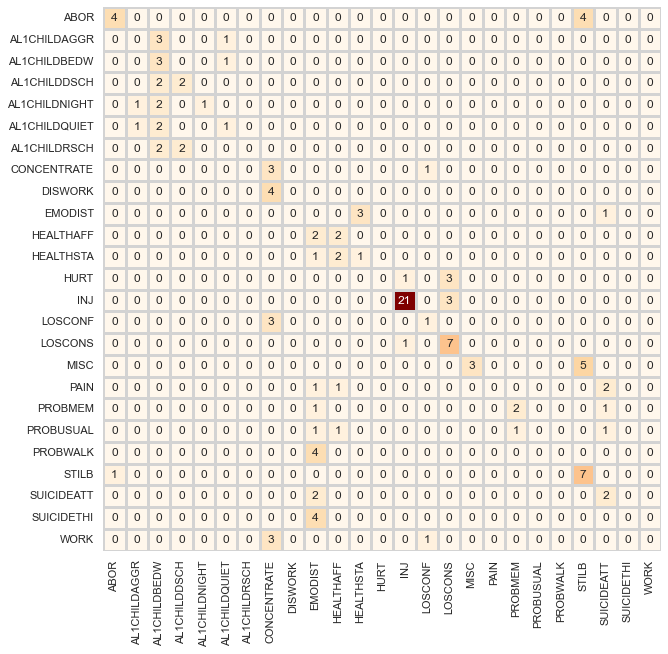

In [52]:
# HeatMap
conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), 
                              y.cat.categories, y.cat.categories)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_df, annot=True, cmap="OrRd", annot_kws={'size':12},cbar=False, 
            linewidths=1.2, linecolor="lightgrey")
plt.show()

#### Predict unknown values

In [53]:
df_unk = df[ df["OUTCOME"].isna() ].copy()

In [54]:
# Follow the same pipeline as before to convert this dataframe to a format that can be passed in a classifier

X_unk = df_unk.drop(columns=["OUTCOME"])
X_unk_cp = X_unk.copy()

column_names = X_unk.columns

In [55]:
X_unk = X_unk.drop(columns=["TIME_PERIOD"])
X_unk = X_unk[X.columns]

In [56]:
X_unk["OBS_VALUE"] = imputer_numeric.transform(X_unk["OBS_VALUE"].values.reshape(-1,1))
X_unk = pd.DataFrame(imputer.transform(X_unk), columns=X_unk.columns)
X_unk = col_transformer_train.transform(X_unk).toarray()

In [57]:
y_unk = le.inverse_transform(clf.predict(X_unk).ravel())

In [58]:
predicted_df = pd.concat([X_unk_cp, pd.DataFrame(y_unk, index=X_unk_cp.index, 
                        columns=["PREDICTED_OUTCOME"])], axis="columns")

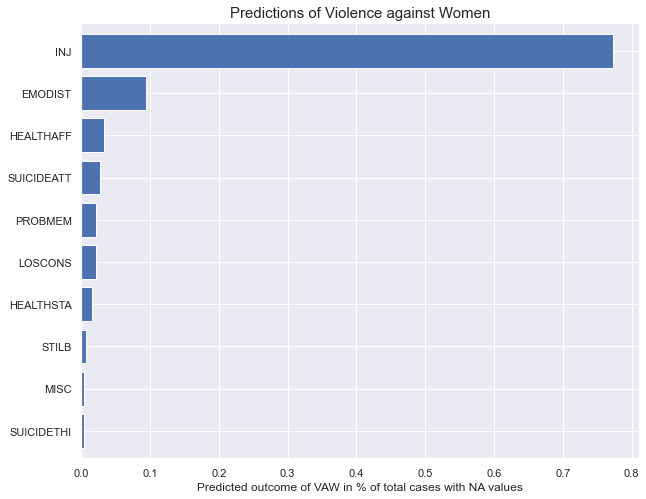

In [59]:
ax = predicted_df["PREDICTED_OUTCOME"].value_counts(normalize=True, ascending=True).plot.barh(
                                                                            figsize=(10,8), width=.8)

ax.set_title("Predictions of Violence against Women",fontsize=15)
ax.set_xlabel("Predicted outcome of VAW in % of total cases with NA values", fontsize=12)

plt.show()

In [60]:
# Write final DF with the predictions to a CSV file
try:
    predicted_df.to_csv("Predict_VAW.csv", na_rep="NA", float_format="%.2f", index=False, encoding="utf-8")
except IOError as e:
    print("ERROR when trying to write to file", e)